In [0]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.distributions as distb

import os
import sys
import time
from datetime import datetime
import argparse

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from pprint import pprint
from torch.utils.data import Dataset
from collections import Counter
from torch.distributions.normal import Normal


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [0]:
from pprint import pprint
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import Counter

class BaseTreeData(Dataset):
    def __init__(self, train_data_path="02-21.10way.clean", rare_threshold=1):
        self.rare_threshold = rare_threshold
        self.base_data = self.remove_tags(open(train_data_path, "r").read())
        self.SOS = "|new"
        self.EOS = "."
        self.pad = "<_>"
        self.rare = "RARE"
        self.base_data.extend([self.SOS for i in range(self.rare_threshold + 1)])
        self.base_data.extend([self.pad for i in range(self.rare_threshold + 1)])
        self.base_data.extend([self.rare for i in range(self.rare_threshold + 1)])

        self.vocab = list(set(self.base_data))        
        self.define_mappings()

        # self.sentences = [sentence for sentence in self.read_sentence(self.base_data)]
        self.max_sentence_len = self.largest_sentence()

    def define_mappings(self):
        self.word_counter = Counter(self.base_data)
        self.word2idx = {}
        self.idx2word = {}
        idx = 0
        for w in self.vocab:
            if self.word_counter[w] > self.rare_threshold:
                self.word2idx[w] = idx
                self.idx2word[idx] = w
                idx+=1
        self.vocab_size = len(self.word2idx)
        
    def __getitem__(self, idx):
        # sentence = self.sentences[idx]
        # inputs =  [self.word2idx[w] if self.word_counter[w] > self.rare_threshold else self.word2idx[self.rare] for w in sentence]
        # targets = [self.word2idx[w] if self.word_counter[w] > self.rare_threshold else self.word2idx[self.rare] for w in sentence[1:]]
        # # add padding
        # inputs.extend([self.word2idx[self.pad] for i in range(self.max_sentence_len - len(inputs))])
        # targets.extend([self.word2idx[self.pad] for i in range(self.max_sentence_len - len(targets))])
        # batch = (inputs, targets)
        # return batch, len(sentence)
        raise NotImplementedError

    def read_sentence(self, data):
        sentence = [self.SOS]
        for word in data:
            sentence.append(word)
            if word == self.EOS:
                yield sentence
                sentence = [self.SOS]

    def remove_tags(self, data):
        """
        Remove tree tags from Penn Treebank dataset
        """
        data = data.split(")")
        out = []
        for e in data:
            e = e.split(" ")
            if e[-1] != "":
                out.append(e[-1])
        return out

    def largest_sentence(self):
        max_len = 0
        for sentence in self.read_sentence(self.base_data):
            if len(sentence) > max_len:
                max_len = len(sentence)
        return max_len

    def convert_to_string(self, char_idx):
        return ' '.join(self.idx2word[idx] for idx in char_idx)

    def convert_to_idx(self, chars):
        return [self.word2idx[char] for char in chars]

    def __len__(self):
        # return len(self.sentences)
        raise NotImplementedError


class PennTreeData(BaseTreeData):
    def __init__(self, data_path):
        super().__init__()
        self.data = self.remove_tags(open(data_path, "r").read())
        self.sentences = [sentence for sentence in self.read_sentence(self.data)]

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        inputs =  [self.word2idx[w] if self.word_counter[w] > self.rare_threshold else self.word2idx[self.rare] for w in sentence]
        targets = [self.word2idx[w] if self.word_counter[w] > self.rare_threshold else self.word2idx[self.rare] for w in sentence[1:]]
        # add padding
        inputs.extend([self.word2idx[self.pad] for i in range(self.max_sentence_len - len(inputs))])
        targets.extend([self.word2idx[self.pad] for i in range(self.max_sentence_len - len(targets))])
        batch = (inputs, targets)
        return batch, len(sentence)
        
    def __len__(self):
      return len(self.sentences)

In [0]:
class encoder(nn.Module):
  
  def __init__(self, vocabulary_size, emb_dim, hidden_dim, lstm_layers, latent_size, device = 'cuda:0', dropout = 0):
    
    super(encoder,self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocabulary_size,embedding_dim=emb_dim)
    self.lstm = nn.LSTM(input_size = emb_dim, hidden_size = hidden_dim, num_layers=lstm_layers, batch_first=False, bidirectional = True)
    self.mean_encoding = nn.Linear(hidden_dim * 2, latent_size)
    self.sd_encoding = nn.Linear(hidden_dim * 2, latent_size)
    self.softplus = nn.Softplus()
#     self.dropout = dropout                 #do later
#     self.emb_dropout = nn.Dropout(p)
    
  def forward(self, x, hid = None):
    
    x = x.to(device)
    x = self.embedding(x)
    
    _ , hidden = self.lstm(x, hid)
    
    h = torch.cat([hidden[0], hidden[1]], dim=-1)
    
#     hidden = torch.stack(hidden).view(hidden[0].size(0),hidden[0].size(1),-1)
    
    mean = self.mean_encoding(h)

    sd = self.softplus(self.sd_encoding(h))
    
    logvar = None
    
    return mean, logvar, sd

In [0]:
#USING THE BASELINE WITH SOME MODIFICATIONS AS DECODER

class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, bidirectional, embedding_dim,
                 lstm_num_hidden=512, lstm_num_layers=3, device='cuda:0'):
        super(RNNLM, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                      embedding_dim=embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=lstm_num_hidden,
                            num_layers=lstm_num_layers,
                            batch_first=False, bidirectional = bidirectional)
        
        
        self.linear = nn.Linear(lstm_num_hidden*2, vocabulary_size)
        
    def forward(self, x, hidden = None, flag = True):
        
        x = self.embedding(x)
        all_hidden, hidden = self.lstm(x, (hidden, hidden))
        out = self.linear(all_hidden)

        return out, hidden


In [0]:
class senvae(nn.Module):
  
  def __init__(self, emb_dim, padding_index, vocab_size, hidden_dim, lstm_layers, latent_size, epoch = 1, device = 'cuda:0' ):
    
    super(senvae,self).__init__()
    
    self.encoder = encoder(vocab_size, emb_dim, hidden_dim , lstm_layers, latent_size, device = 'cuda:0', dropout = 0)
    self.latent_dim = latent_size
    self.hidden_dim = hidden_dim
    self.pad_idx = padding_index
    self.emb_dim = emb_dim
    self.vocab_size = vocab_size
    self.lstm_layers = lstm_layers
    self.epsilon = 1e-7
    self.tanh = nn.Tanh()
    self.latenttohidden = nn.Linear(latent_size, hidden_dim)
    self.criterion = nn.CrossEntropyLoss(ignore_index = padding_index)
    self.nllcriterion = nn.CrossEntropyLoss(ignore_index = padding_index) #, reduction = 'None')
    self.recons_loss = torch.zeros([2 * self.lstm_layers, 1])
    self.decoder = RNNLM(vocab_size, bidirectional=True, embedding_dim=emb_dim,
                 lstm_num_hidden=hidden_dim, lstm_num_layers=lstm_layers, device='cuda:0')  

  def forward(self, x, targets, n = 10):
       
    mean, logvar, sd = self.encoder(x)
    
    kl_loss = (sd ** 2 + mean**2 - ((sd) ** 2 + self.epsilon).log() - 1).sum(1).sum(1) * 0.5
    
    #calculating loss for multisample ELBO
    
    r = torch.FloatTensor([0]).to(device)
    
    for i in range(n):
    
      z = torch.randn([x.size(1), self.latent_dim]).to(device)
      
      z = z * sd + mean

      h = self.tanh(self.latenttohidden(z))

      output, _ = self.decoder(x, h)
      output = output.view(x.size()[0]* x.size()[1], -1)

      reconstruction_loss = F.cross_entropy(output, targets, ignore_index=self.pad_idx, 
                                                reduction="none")
      
      r += reconstruction_loss.sum(dim=0)
 
    rl = torch.div(r,n)  
    total_loss = kl_loss.mean()  + rl
    
    h0 = self.tanh(self.latenttohidden(mean))
    out, _ = self.decoder(x, h0)
    
    nll = None
    return out, total_loss, nll  
  
  def temperature_sample(self, h, temperature):
    h = h.squeeze()
    distribution = torch.softmax(h/temperature, dim=0)    
    return torch.multinomial(distribution,1).item()
  
  def test(self,dataset, first_word, device, decoding = "greedy", flag = True, max_len = 20, temperature = 2.0):

    
    with torch.no_grad():
      x = torch.tensor(first_word, dtype=torch.long, device=device).view(1,1)
      sentence = [x.item()]
      mean, _ ,  sd = self.encoder(x)
      eps = distb.MultivariateNormal(torch.zeros(mean.size(2)).to(device = 'cuda:0'), torch.eye(mean.size(2)).to(device = 'cuda:0'))
      z = mean + eps.sample() * sd  
      if(flag):
        h0 = self.tanh(self.latenttohidden(mean)) 
      else:
        h0 = self.tanh(self.latenttohidden(z)) 
      
      # use this z for predicting all the words until '.' is found
      all_hidden, hidden = self.decoder(x , h0)
      
      if(decoding == "greedy"):
        sampled_word = torch.argmax(all_hidden, dim=2).item()
      else:
        sampled_word = self.temperature_sample(all_hidden, temperature)
      sentence.append(sampled_word)
      x = torch.tensor(sampled_word, dtype=torch.long, device=device).view(1,1)
      
      while(sentence[-1] != dataset.EOS and len(sentence) < max_len):
        all_hidden, hidden = self.decoder(x, h0)
        if(decoding == "greedy"):
          sampled_word = torch.argmax(all_hidden, dim=2).item()
        else:
          sampled_word = self.temperature_sample(all_hidden, temperature)
        sentence.append(sampled_word)
        x = torch.tensor(sampled_word, dtype=torch.long, device=device).view(1,1)

    return(sentence)

  def test_interpolate(self,dataset, first_word, mean, sd, decoding = "greedy", flag = True, max_len = 20, temperature = 2.0):

    
    with torch.no_grad():
      x = torch.tensor(first_word, dtype=torch.long, device=device).view(1,1)
      sentence = [x.item()]
      eps = distb.MultivariateNormal(torch.zeros(mean.size(2)).to(device = 'cuda:0'), torch.eye(mean.size(2)).to(device = 'cuda:0'))
      z = mean + eps.sample() * sd  
      if(flag):
        h0 = self.tanh(self.latenttohidden(mean)) 
      else:
        h0 = self.tanh(self.latenttohidden(z)) 
      
      # use this z for predicting all the words until '.' is found
      all_hidden, hidden = self.decoder(x , h0)
      
      if(decoding == "greedy"):
        sampled_word = torch.argmax(all_hidden, dim=2).item()
      else:
        sampled_word = self.temperature_sample(all_hidden, temperature)
      sentence.append(sampled_word)
      x = torch.tensor(sampled_word, dtype=torch.long, device=device).view(1,1)
      
      while(sentence[-1] != dataset.EOS and len(sentence) < max_len):
        all_hidden, hidden = self.decoder(x, h0)
        if(decoding == "greedy"):
          sampled_word = torch.argmax(all_hidden, dim=2).item()
        else:
          sampled_word = self.temperature_sample(all_hidden, temperature)
        sentence.append(sampled_word)
        x = torch.tensor(sampled_word, dtype=torch.long, device=device).view(1,1)

    return(sentence)

  def perplexity(self, model, dataloader, n = 5):
    
    #calculate perlpexity for entire dataset
    log_px = 0.
    num_sen = 0
    num_preds = 0
    accuracies = []
    with torch.no_grad():
    
      for step, (batch, sen_lens) in enumerate(dataloader):

        batch_inputs, batch_targets = batch
            
        batch_inputs = torch.stack(batch_inputs).to(device)
        batch_targets = torch.stack(batch_targets).to(device).view(-1)
        
        mean,logvar, sd = self.encoder(batch_inputs)
        
        likelihoods = torch.FloatTensor(n,2,100).to(device)
        losses = []
        for i in range(n):

          z = torch.randn([batch_inputs.size(1), self.latent_dim]).to(device)
          z = z * sd + mean
          h = self.tanh(self.latenttohidden(z))
      
          output, _ = self.decoder(batch_inputs, h)
          output = output.view(batch_inputs.size()[0]* batch_inputs.size()[1], -1)
          accuracy = (output.argmax(1) == batch_targets).float().sum()/(batch_targets != 0).sum()
          accuracies.append(accuracy.item())
          
          #p(x|z)
          logprob = F.cross_entropy(output, batch_targets, reduction="sum")

          # Calculate p(z|prior) and p(z|encoding) 
          
          #prior_pz
          prior = Normal(torch.zeros((mean.shape[1], self.latent_dim), device = device),torch.ones((mean.shape[1], self.latent_dim), device = device))
          #posterior_qz
          encoded_distribution = Normal(mean, sd)
          normalizer = (prior.log_prob(z).exp()/encoded_distribution.log_prob(z).exp()).prod(1).unsqueeze(1)
          
          a = prior.log_prob(z).sum(dim = 1)
          b = encoded_distribution.log_prob(z).sum(dim = 1)
          c = logprob + a - b
 
          d = logprob*normalizer +(logprob == 0).float()

          likelihoods[i] = c
        

        log_px_batch = torch.logsumexp(likelihoods, dim = 0) - torch.log(torch.Tensor([n]).to(device))
        log_px += log_px_batch.sum(-1)
  
        num_sen += sen_lens.size(0)
        num_preds += sen_lens.sum()
    
    perplexity = log_px / (num_preds * batch_inputs.size(1))
    NLL = log_px / num_sen
    
    return perplexity.mean(), NLL.mean(), np.mean(accuracies)

In [0]:
def ELBO(model, dataloader, n = 10):
  
#   model.eval()
  
  with torch.no_grad():
    
    rec_loss = torch.FloatTensor([0]).to(device)
    kld = torch.FloatTensor([0]).to(device)
    num_sen = 0
    for step, (batch, sen_lens) in enumerate(dataloader):
      
      batch_inputs, batch_targets = batch      
      batch_inputs = torch.stack(batch_inputs).to(device)
      batch_targets = torch.stack(batch_targets).to(device).view(-1)

      mean, _ , sd = model.encoder(batch_inputs)
      

      kl_loss = (sd ** 2 + mean**2 - ((sd ** 2) + model.epsilon).log() - 1).sum(1).sum(1) * 0.5

      
      #calculating loss for multisample ELBO

      r = torch.FloatTensor([0]).to(device)
      for i in range(n):

        z = torch.randn([batch_inputs.size(1), model.latent_dim]).to(device)

        z = z * sd + mean

        h = model.tanh(model.latenttohidden(z))

        output, _ = model.decoder(batch_inputs, h)
        output = output.view(batch_inputs.size()[0]* batch_inputs.size()[1], -1)

        reconstruction_loss = F.cross_entropy(output, batch_targets, ignore_index= model.pad_idx, 
                                                  reduction="none")

        r += reconstruction_loss.sum(dim=0)

      rec_loss += r
#       rec_loss = torch.div(rec_loss, n)
      kld += kl_loss.mean()
      num_sen += batch_inputs.size(1) #batch size
      
    #Average values
    rec_loss = torch.div(rec_loss,num_sen)
    normalizer = num_sen * (step + 1)
    kld1 = torch.div(kld, normalizer)
    kld2 = torch.div(kld, num_sen)
    elbo = rec_loss + kld1
    
  return elbo.item() , kld1.item()
    

In [0]:
def interpolation(test_dataset, test_data_loader, idx1, idx2, model):
  
  with torch.no_grad():

    for i,j in test_data_loader:
      s1 = []
      s2 = []
      for k in range(16):
        #inside a [batch])
        for a in i[k]:
          #inside one batch element
          b = a[idx1]
          c = a[idx2]
          s1.append(b)
          s2.append(c)
        break
      break
    a = torch.zeros(140,1).to(device)
    d = torch.zeros(140,1).to(device)
    for i in range(140):
      a[i] = s1[i]
      d[i] = s2[i]

    print("First original statement")
    for i in a:
      print(test_dataset.idx2word[i.item()], end = " ")
    print("\n2nd original statement")
    for i in d:
      print(test_dataset.idx2word[i.item()], end = " ")
    print("")
    s1 = a
    s1 = s1.long().to(device)
    s2 = d
    s2 = s2.long().to(device)

    mean1, _, sd1 = model.encoder(s1)
    mean2, _, sd2 = model.encoder(s2)

    mean_diff = (mean2 - mean1)/(idx2-idx1 +1)
    means = [mean1 + mean_diff*i for i in range(10)]

    for i, mean in enumerate(means):
      generated_sample =  model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS], mean, sd1, decoding = "greedy", flag = True)
      print("Interpolated reconstruction: ",test_dataset.convert_to_string(generated_sample))

def reconstruct(model, test_dataset, test_data_loader, idx):
  
  with torch.no_grad():

    for i,j in test_data_loader:
      s1 = []
      for k in range(16):
        #inside a [batch])
        for a in i[k]:
          #inside one batch element
          b = a[idx]
          s1.append(b)
        break
      break
    a = torch.zeros(140,1).to(device)
    for i in range(140):
      a[i] = s1[i]

    print("Original statement")
    for i in a:
      print(test_dataset.idx2word[i.item()], end = " ")
    print("")
    s1 = a
    s1 = s1.long().to(device)
    mean, _, sd = model.encoder(s1)

    #flag = true for mean
    generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "greedy", flag = True)
    print("SAMPLE (gmean)", ":", test_dataset.convert_to_string(generated_sample))
    generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "temp", flag = True)
    print("SAMPLE (tmean)", ":", test_dataset.convert_to_string(generated_sample))

    #flag = false for z
    for i in range(10):
      generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "greedy", flag = False)
      print("SAMPLE_g", i+1, ":", test_dataset.convert_to_string(generated_sample))
      generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "temp", flag = False)
      print("SAMPLE_t", i+1, ":", test_dataset.convert_to_string(generated_sample))
    
def reconstruct_val(model, test_dataset, test_data_loader, idx):
  
  with torch.no_grad():

    for i,j in test_data_loader:
      s1 = []
      for k in range(16):
        #inside a [batch])
        for a in i[k]:
          #inside one batch element
          b = a[idx]
          s1.append(b)
        break
      break
    a = torch.zeros(140,1).to(device)
    for i in range(140):
      a[i] = s1[i]

    print("Original statement")
    for i in a:
      print(test_dataset.idx2word[i.item()], end = " ")
    print("")
    s1 = a
    s1 = s1.long().to(device)
    mean, _, sd = model.encoder(s1)

    #flag = true for mean
    generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "greedy", flag = True)
    print("SAMPLE (gmean)", ":", test_dataset.convert_to_string(generated_sample))
    generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "temp", flag = True)
    print("SAMPLE (tmean)", ":", test_dataset.convert_to_string(generated_sample))

    #flag = false for z
    for i in range(1):
      generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "greedy", flag = False)
      print("SAMPLE (gz)", ":", test_dataset.convert_to_string(generated_sample))
      generated_sample = model.test_interpolate(test_dataset, test_dataset.word2idx[test_dataset.SOS],mean, sd, decoding = "temp", flag = False)
      print("SAMPLE (tz)", ":", test_dataset.convert_to_string(generated_sample))
  
  

In [0]:
TRAIN_TEXT_FILE = "02-21.10way.clean"
EVAL_TEXT_FILE = "22.auto.clean"
TEST_TEXT_FILE = "23.auto.clean"
  
def train():
  
    
    batch_size = 32
    embedding_dimension = 128
    lstm_num_hidden_l = 128
    lstm_num_layers_l = 1
    learning_rate = 0.001
    n_epochs = 10
    sample_method = 'greedy'
    latent_size = 100
    
    # Initialize the dataset and data loader (note the +1)
    train_dataset = PennTreeData(TRAIN_TEXT_FILE)
    train_data_loader = DataLoader(train_dataset, batch_size, num_workers=1)
    eval_dataset = PennTreeData(EVAL_TEXT_FILE)
    eval_data_loader = DataLoader(eval_dataset, batch_size, num_workers=1)
    test_dataset = PennTreeData(TEST_TEXT_FILE)
    test_data_loader = DataLoader(test_dataset, batch_size, num_workers=1)
    
    # Initialize the model that we are going to use
    model = senvae (embedding_dimension, train_dataset.word2idx[train_dataset.pad],  
                    train_dataset.vocab_size, lstm_num_hidden_l, lstm_num_layers_l,
                    latent_size, device = 'cuda:0' )
    model.to(device)
    model.train()
    # Setup the loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index = train_dataset.word2idx[train_dataset.pad])
    optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
    
    train_elbo = []
    train_accuracies = []
    val_elbo = []
    val_accuracies = []
    val_kld = []
    val_ppl = []
    val_nll = []
    for epoch in range(n_epochs):
        print("In epoch", epoch)
        for step, (batch, sen_lens) in enumerate(train_data_loader):
            
            model.zero_grad()
            batch_inputs, batch_targets = batch
            
            # Only for time measurement of step through network
            t1 = time.time()
            batch_inputs = torch.stack(batch_inputs).to(device)
            batch_targets = torch.stack(batch_targets).to(device).view(-1)

  
            output, loss, nll = model(batch_inputs, batch_targets)

            output = output.view(batch_inputs.size()[0] * batch_inputs.size()[1], -1)
            tloss = criterion(output,batch_targets)
            accuracy = (output.argmax(1) == batch_targets).float().sum()/(batch_targets != 0).sum()
            elbo = -loss            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            optimizer.zero_grad()
            # For plotting
            train_accuracies.append(accuracy)
            train_elbo.append(-loss.item())
            
            # Just for time measurement
            t2 = time.time()
            examples_per_second = batch_size/float(t2-t1)
           
            if step % 100 == 0 : #config.print_every == 0:
                print("[{}] Epoch {} Train Step {:00f}, Batch Size = {}, Examples/Sec = {:.2f}, "
                    "Accuracy = {:.3f}, Loss = {:.5f} ".format(
                        datetime.now().strftime("%Y-%m-%d %H:%M"), epoch, step,
                        batch_size, examples_per_second,
                        accuracy, loss.item()))
           
          
                print("Epoch", epoch, " completed")
                model.eval()
                ppl, nll, acc = model.perplexity(model, eval_data_loader, n =10)
                elbo, kld = ELBO(model, eval_data_loader)
                val_accuracies.append(acc)
                val_elbo.append(-elbo)
                val_kld.append(kld)
                val_ppl.append(ppl)
                val_nll.append(nll)
                print("Validation metrics: Batch Size = {}, Accuracy = {}, KL-D = {}, ELBO = {}," 
                      "Perplexity = {}, NLL = {} ".format(
                          batch_size, acc, kld, elbo, ppl.item(), nll.item()))
                generated_sample = reconstruct_val(model, eval_dataset, eval_data_loader, 1)
#                 model.train()
                break
        break

    print('Done training! Evaluating test set now')
    model.eval()
    ppl, nll, acc = model.perplexity(model, test_data_loader, n =10)
    elbo, kld = ELBO(model, test_data_loader)
    print("Test metrics: Batch Size = {}, Accuracy = {}, KL-D = {}, ELBO = {}," 
          "Perplexity = {}, NLL = {} ".format(
              batch_size, acc, kld, elbo, ppl.item(), nll.item()))
    print("**************RECONSTRUCTION CAPABILITY***************************")
    reconstruct(model, test_dataset, test_data_loader, 1)
    print("****************INTERPOLATION CAPABILITY**************************")
    interpolation(test_dataset, test_data_loader, 0, 9, model)
      
    plt.plot(train_elbo, label = "Train Loss")
    plt.legend()
    plt.savefig("train_elbo.png")
    plt.close()
    
    plt.plot(train_accuracies, label = "Train accuracy")
    plt.legend()
    plt.savefig("train_acc.png")
    plt.close()
    
    plt.plot(val_elbo, label = "Validation Loss")
    plt.legend()
    plt.savefig("val_elbo.png")
    plt.close()
    
    plt.plot(val_accuracies, label = "Val accuracy")
    plt.legend()
    plt.savefig("val_acc.png")
    plt.close()
    
    plt.plot(val_kld, label = "val kld")
    plt.legend()
    plt.savefig("val_kld.png")
    plt.close()
    
    return model, train_elbo, train_accuracies, val_elbo, val_accuracies, val_kld , val_ppl, val_nll


In [0]:
model, train_elbo, train_accuracies, val_elbo, val_accuracies, val_kld, val_ppl, val_nll  = train()


In [0]:
# np.save("train_elbo", train_elbo)
# np.save("train_acc", train_accuracies)
# np.save("val_elbo", val_elbo)
# np.save("val_accuracies", val_accuracies)
# np.save("val_kld", val_kld)
# np.save("val_ppl", val_ppl)
# np.save("val_nll", val_nll)


In [0]:
torch.save(model.state_dict(), "svae.pt")

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [0]:
from shutil import copyfile

copyfile('svae.pt', '/content/gdrive/My Drive/' + 'svae.pt')

'/content/gdrive/My Drive/svae.pt'

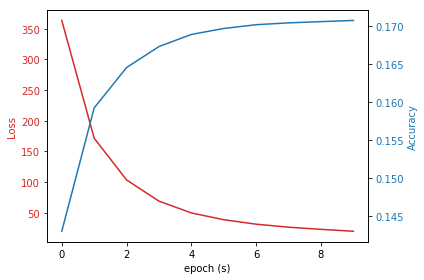

In [0]:
# import numpy as np
# from matplotlib import pyplot as plt

# a = np.load("train_elbo.npy")
# b = np.load("val_elbo.npy")
# c = np.load("val_accuracies.npy")
# b = b * -1
# # plt.plot(a)
# # plt.plot(b)
# # plt.plot(c)



# fig, ax1 = plt.subplots()
# t = np.arange(0,10)
# color = 'tab:red'
# ax1.set_xlabel('epoch (s)')
# ax1.set_ylabel('Loss', color=color)
# ax1.plot(t,b, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, c, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()